In [69]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
cd drive/My\ Drive/Colab\ Notebooks/MNIST_GAN

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/MNIST_GAN'
/content/drive/My Drive/Colab Notebooks/MNIST_GAN


In [0]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from matplotlib.pyplot import imshow
import json

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [0]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [0]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [0]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [0]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [0]:
G.load_state_dict(torch.load('modelparameters/generator_parameters.pt'))
G.eval()

D.load_state_dict(torch.load('modelparameters/discriminator_parameters.pt'))
D.eval()

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [0]:
#mean_loss_d = []
#mean_loss_g = []
with open('mean_loss_d.txt') as json_file:
    mean_loss_d = json.load(json_file)
with open('mean_loss_g.txt') as json_file:
    mean_loss_g = json.load(json_file)


In [0]:
n_epoch = 50

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    mean_loss_d.append(torch.mean(torch.FloatTensor(D_losses)).item())
    mean_loss_g.append(torch.mean(torch.FloatTensor(G_losses)).item())
    
    with torch.no_grad():
        test_z = Variable(torch.randn(bs, z_dim).to(device))
        generated = G(test_z)
        save_image(generated.view(generated.size(0), 1, 28, 28), 'samples/sample_epoch_' + str(epoch+50) + '.png')

torch.save(G.state_dict(), 'modelparameters/generator_parameters.pt')
torch.save(D.state_dict(), 'modelparameters/discriminator_parameters.pt')
print('saved states')

with open('mean_loss_d.txt', 'w') as outfile:
    json.dump(mean_loss_d, outfile)

with open('mean_loss_g.txt', 'w') as outfile:
    json.dump(mean_loss_g, outfile)
print('saved losses')

[1/50]: loss_d: 1.162, loss_g: 1.082
[2/50]: loss_d: 1.175, loss_g: 1.076
[3/50]: loss_d: 1.170, loss_g: 1.089
[4/50]: loss_d: 1.178, loss_g: 1.057
[5/50]: loss_d: 1.183, loss_g: 1.047
[6/50]: loss_d: 1.190, loss_g: 1.046
[7/50]: loss_d: 1.188, loss_g: 1.054
[8/50]: loss_d: 1.188, loss_g: 1.039
[9/50]: loss_d: 1.199, loss_g: 1.034
[10/50]: loss_d: 1.188, loss_g: 1.055
[11/50]: loss_d: 1.194, loss_g: 1.020
[12/50]: loss_d: 1.200, loss_g: 1.034
[13/50]: loss_d: 1.199, loss_g: 1.018
[14/50]: loss_d: 1.208, loss_g: 1.010
[15/50]: loss_d: 1.195, loss_g: 1.033
[16/50]: loss_d: 1.207, loss_g: 1.016
[17/50]: loss_d: 1.209, loss_g: 1.005
[18/50]: loss_d: 1.211, loss_g: 1.018
[19/50]: loss_d: 1.219, loss_g: 1.004
[20/50]: loss_d: 1.216, loss_g: 0.992
[21/50]: loss_d: 1.218, loss_g: 0.985
[22/50]: loss_d: 1.224, loss_g: 0.983
[23/50]: loss_d: 1.226, loss_g: 0.979
[24/50]: loss_d: 1.219, loss_g: 0.995
[25/50]: loss_d: 1.228, loss_g: 0.973
[26/50]: loss_d: 1.226, loss_g: 0.982
[27/50]: loss_d: 1.22

In [0]:
torch.save(G.state_dict(), 'modelparameters/generator_parameters.pt')
torch.save(D.state_dict(), 'modelparameters/discriminator_parameters.pt')

In [0]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')

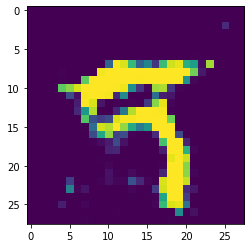

In [114]:
with torch.no_grad():
    test_z = Variable(torch.randn(1, z_dim).to(device))
    generated = G(test_z)
    imshow(generated.view(28, 28))

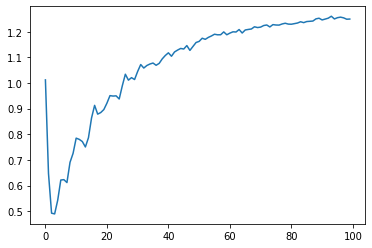

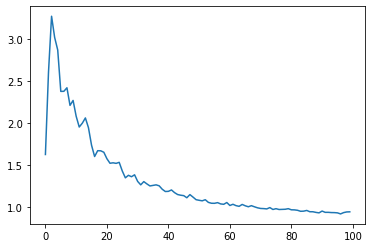

In [72]:
import matplotlib.pyplot as plt

plt.plot(mean_loss_d)
plt.show()

plt.plot(mean_loss_g)
plt.show()

In [0]:
import json

with open('mean_loss_d.txt', 'w') as outfile:
    json.dump(mean_loss_d, outfile)

#with open('mean_loss_d.txt') as json_file:
#    data = json.load(json_file)

with open('mean_loss_g.txt', 'w') as outfile:
    json.dump(mean_loss_g, outfile)

#with open('mean_loss_g.txt') as json_file:
#    data = json.load(json_file)


[1.0407308340072632, 1.0502651929855347, 1.0805355310440063]


In [0]:
torch.save(G.state_dict(), 'modelparameters/generator_parameters.pt')
torch.save(D.state_dict(), 'modelparameters/discriminator_parameters.pt')